In [21]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Data Processing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

# Get variable names
# from varname import nameof

# Pipeline diagram
from sklearn import set_config

# MODELS
# from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, roc_auc_score

In [22]:
ausencias = pd.read_csv('./data/raw/Ausencias.csv')
definitivas = pd.read_csv('./data/raw/Definitivas_asignaturas.csv')
estudiantes = pd.read_csv('./data/raw/Listado_estudiantes.csv')
psat = pd.read_csv('./data/raw/Pruebas_PSAT.csv')
saber_11 = pd.read_csv('./data/raw/Pruebas_Saber_11.csv')
simulacro = pd.read_csv('./data/raw/Simulacro_pruebas_saber_11.csv')


In [23]:
saber_11 = saber_11.pivot_table(index=['codigo','anio_escolar'], columns=['asignatura'],values='resultado').reset_index()
saber_11 = saber_11.rename_axis(None, axis=1)
saber_11.columns = [f'{j.lower().replace("","ni").replace(" ","_").strip()}_saber_11'  for j in saber_11.columns ]
saber_11.rename(columns={f'codigo_saber_11':'codigo'}, inplace= True)
del saber_11['anio_escolar_saber_11']
del saber_11['global_saber_11']
saber_11_materias = [ j for j in saber_11.columns if j.endswith('saber_11') ]
for i in saber_11_materias:
    if i == 'ingles_saber_11':
        saber_11[i] = saber_11[i].apply(lambda x: 1 if x >=80 else 0)
    else:
        saber_11[i] = saber_11[i].apply(lambda x: 1 if x >=60 else 0)


In [24]:
psat = psat.pivot_table(index=['codigo','anio_escolar'], columns=['asignatura'],values='resultado').reset_index()
psat.drop_duplicates(subset= 'codigo', keep= 'first', inplace = True)
psat = psat.rename_axis(None, axis=1)
psat.columns = [f'{j.lower().replace(" ","_").strip()}_psat'  for j in psat.columns ]
psat.rename(columns={f'codigo_psat':'codigo'}, inplace= True)
del psat['anio_escolar_psat']
del psat['combinado_psat']

In [25]:
definitivas_10 = definitivas[definitivas.grado == 10]
definitivas_10 = definitivas_10.groupby(['codigo','asignatura'])['resultado'].mean().to_frame().reset_index()
definitivas_10 = definitivas_10.pivot_table(index=['codigo'], columns=['asignatura'],values='resultado').reset_index()
definitivas_10 = definitivas_10.rename_axis(None, axis=1)
definitivas_10.columns = [f'{j.lower().replace(" ","_").replace("","ni").strip()}_notas_10'  for j in definitivas_10.columns ]
definitivas_10.rename(columns={f'codigo_notas_10':'codigo'}, inplace= True)

definitivas_11 = definitivas[definitivas.grado == 11]
definitivas_11 = definitivas_11.groupby(['codigo','asignatura'])['resultado'].mean().to_frame().reset_index()
definitivas_11 = definitivas_11.pivot_table(index=['codigo'], columns=['asignatura'],values='resultado').reset_index()
definitivas_11 = definitivas_11.rename_axis(None, axis=1)
definitivas_11.columns = [f'{j.lower().replace(" ","_").replace("","ni").strip()}_notas_11'  for j in definitivas_11.columns ]
definitivas_11.rename(columns={f'codigo_notas_11':'codigo'}, inplace= True)

definitivas_12 = definitivas[definitivas.grado == 12]
definitivas_12 = definitivas_12.groupby(['codigo','asignatura'])['resultado'].mean().to_frame().reset_index()
definitivas_12 = definitivas_12.pivot_table(index=['codigo'], columns=['asignatura'],values='resultado').reset_index()
definitivas_12 = definitivas_12.rename_axis(None, axis=1)
definitivas_12.columns = [f'{j.lower().replace(" ","_").replace("","ni").strip()}_notas_12'  for j in definitivas_12.columns ]
definitivas_12.rename(columns={f'codigo_notas_12':'codigo'}, inplace= True)

In [26]:
print(simulacro.grado.value_counts())
simulacro['resultado'] = simulacro['resultado'].apply(lambda x: str(x).strip().replace(',','.'))
simulacro['resultado'] = simulacro['resultado'].apply(lambda x: float(x))


simulacro_11 = simulacro[simulacro.grado == 11]
simulacro_11 = simulacro_11.groupby(['codigo','asignatura'])['resultado'].mean().to_frame().reset_index()
simulacro_11 = simulacro_11.pivot_table(index=['codigo'], columns=['asignatura'],values='resultado').reset_index()
simulacro_11 = simulacro_11.rename_axis(None, axis=1)
simulacro_11.columns = [f'{j.lower().replace(" ","_").replace("","ni").strip()}_sim_11'  for j in simulacro_11.columns ]
simulacro_11.rename(columns={f'codigo_sim_11':'codigo'}, inplace= True)
del simulacro_11['def_sim_11']

simulacro_12 = simulacro[simulacro.grado == 12]
simulacro_12 = simulacro_12.groupby(['codigo','asignatura'])['resultado'].mean().to_frame().reset_index()
simulacro_12 = simulacro_12.pivot_table(index=['codigo'], columns=['asignatura'],values='resultado').reset_index()
simulacro_12 = simulacro_12.rename_axis(None, axis=1)
simulacro_12.columns = [f'{j.lower().replace(" ","_").replace("","ni").strip()}_sim_12'  for j in simulacro_12.columns ]
simulacro_12.rename(columns={f'codigo_sim_12':'codigo'}, inplace= True)
del simulacro_12['def_sim_12']

12    10829
11     6694
Name: grado, dtype: int64


In [27]:
df_10 = definitivas_10.merge(saber_11, on = 'codigo', how = 'inner')
df_10 = df_10.merge(psat, on = 'codigo', how = 'inner')

In [28]:
df_11 = definitivas_11.merge(saber_11, on = 'codigo', how = 'inner')
df_11 = df_11.merge(simulacro_11, on = 'codigo', how = 'inner')
del df_11['ciencias_sociales_notas_11']
df_11.dropna(inplace=True)

In [29]:
df_12 = definitivas_12.merge(saber_11, on = 'codigo', how = 'inner')
df_12 = df_12.merge(simulacro_12, on = 'codigo', how = 'inner')
df_12.dropna(inplace=True)

In [30]:
def keep_materia_saber(df:pd.DataFrame,materia:str)->pd.DataFrame:
    """Get Rid all the saber 11 values, and just keep the "materia" result of the parameter

    Args:
        df (pd.DataFrame): Dataframe with all the columns (all saber 11 scores)
        materia (str): the name of the target

    Returns:
        (pd.DataFrame): the dataframe transformed with target value corresponding to the "materia" saber 11
    """
    col_add = df[[materia]].copy()
    columns = [ i for i in df.columns if not i.endswith('saber_11') ]
    df = df[columns]
    df[materia] = col_add

    return df

math_column = 'matematicas_saber_11'
lectura_column = 'lectura_critica_saber_11'
ingles_column = 'ingles_saber_11'
ciencias_column = 'ciencias_saber_11'
sociales_column = 'sociales_y_ciudadanas_saber_11'

In [31]:
# Matematicas

df_10_MATH = keep_materia_saber(df_10,math_column)
df_11_MATH = keep_materia_saber(df_11,math_column)
df_12_MATH = keep_materia_saber(df_12,math_column)

In [32]:
# lectura
df_10_LECT = keep_materia_saber(df_10,lectura_column)
df_11_LECT = keep_materia_saber(df_11,lectura_column)
df_12_LECT = keep_materia_saber(df_12,lectura_column)

In [33]:
# Ingles
df_10_INGLES= keep_materia_saber(df_10,ingles_column)
df_11_INGLES= keep_materia_saber(df_11,ingles_column)
df_12_INGLES= keep_materia_saber(df_12,ingles_column)


In [34]:
# ciencias_column
df_10_CIENCIAS = keep_materia_saber(df_10,ciencias_column)
df_11_CIENCIAS = keep_materia_saber(df_11,ciencias_column)
df_12_CIENCIAS = keep_materia_saber(df_12,ciencias_column)

In [35]:
# sociales_column
df_10_SOCIALES = keep_materia_saber(df_10,sociales_column)
df_11_SOCIALES = keep_materia_saber(df_11,sociales_column)
df_12_SOCIALES = keep_materia_saber(df_12,sociales_column)

In [36]:
def evaluation(y_test, y_predict, title = 'Confusion Matrix'):
    cm = confusion_matrix(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    accuracy = accuracy_score(y_test,y_predict)
    f1 = f1_score(y_test,y_predict)
    roc = roc_auc_score(y_test, y_predict)
    metrics = {'Accuracy':accuracy,
                'precision':precision,
                'Recall':recall,
                'f1':f1,
                'roc' : roc
                 }

    metrics_df = pd.DataFrame([metrics])
    # print('Recall: ', recall)
    # print('Accuracy: ', accuracy)
    # print('Precision: ', precision)
    # print('F1: ', f1)
    display(metrics_df)
    sns.heatmap(cm,  cmap= 'Blues', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();
    return metrics_df



def plot_feature_importances(model,X_train):
    features = X_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)

    # customized number 
    num_features = 10 

    plt.figure(figsize=(10,10))
    plt.title('Feature Importances')

    # only plot the customized number of features
    plt.barh(range(num_features), importances[indices[-num_features:]], color='black', align='center')
    plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
    plt.xlabel('Relative Importance')
    plt.show()

In [37]:

dataframes = [df_10_MATH,df_10_LECT,df_10_INGLES,df_10_CIENCIAS,df_10_SOCIALES,
df_11_MATH,df_11_LECT,df_11_INGLES,df_11_CIENCIAS,df_11_SOCIALES,
df_12_MATH,df_12_LECT,df_12_INGLES,df_12_CIENCIAS,df_12_SOCIALES]




In [ ]:


df_10_MATH  = pd.read_csv('./data/transformed/df_10_MATH.csv')
df_10_LECT = pd.read_csv('./data/transformed/df_10_LECT.csv')
df_10_INGLES = pd.read_csv('./data/transformed/df_10_INGLES.csv')
df_10_CIENCIAS = pd.read_csv('./data/transformed/df_10_CIENCIAS.csv')
df_10_SOCIALES = pd.read_csv('./data/transformed/df_10_SOCIALES.csv')
df_11_MATH = pd.read_csv('./data/transformed/df_11_MATH.csv')
df_11_LECT = pd.read_csv('./data/transformed/df_11_LECT.csv')
df_11_INGLES = pd.read_csv('./data/transformed/df_11_INGLES.csv')
df_11_CIENCIAS = pd.read_csv('./data/transformed/df_11_CIENCIAS.csv')
df_11_SOCIALES = pd.read_csv('./data/transformed/df_11_SOCIALES.csv')
df_12_MATH = pd.read_csv('./data/transformed/df_12_MATH.csv')
df_12_LECT = pd.read_csv('./data/transformed/df_12_LECT.csv')
df_12_INGLES = pd.read_csv('./data/transformed/df_12_INGLES.csv')
df_12_CIENCIAS = pd.read_csv('./data/transformed/df_12_CIENCIAS.csv')
df_12_SOCIALES = pd.read_csv('./data/transformed/df_12_SOCIALES].csv')




df_10_MATH


,Accuracy,precision,Recall,f1,roc
0,0.807692,0.857143,0.933333,0.893617,0.466667


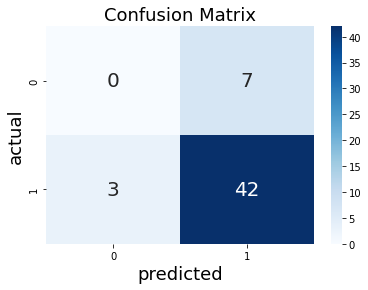

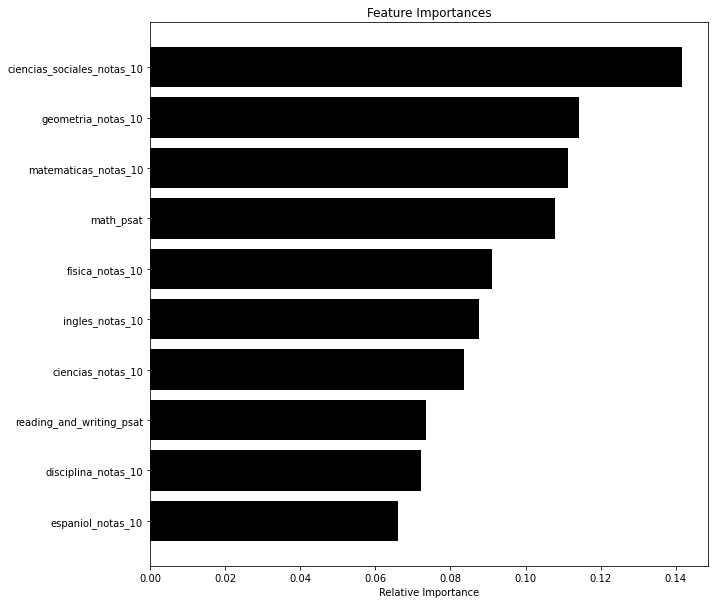

--------------------------------------------------
df_10_LECT


,Accuracy,precision,Recall,f1,roc
0,0.884615,0.884615,1.0,0.938776,0.5


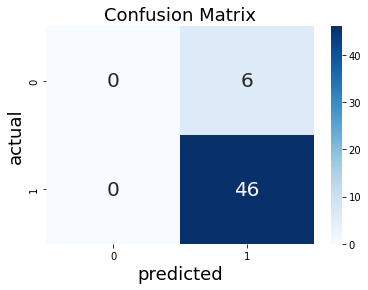

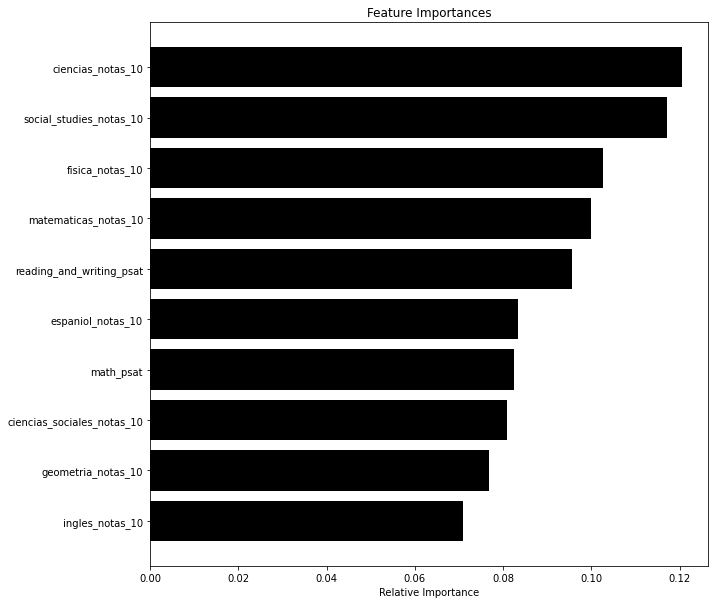

--------------------------------------------------
df_10_INGLES


,Accuracy,precision,Recall,f1,roc
0,0.788462,0.8,0.97561,0.879121,0.533259


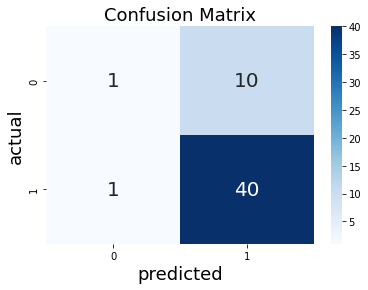

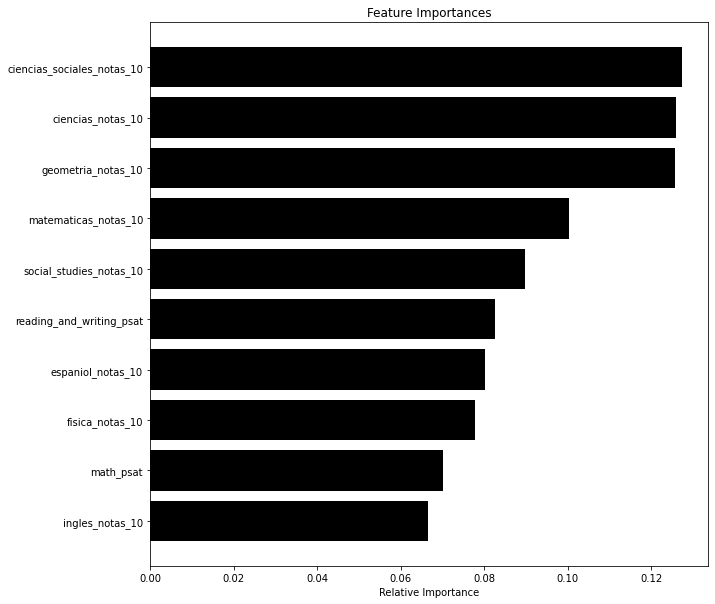

--------------------------------------------------
df_10_CIENCIAS


,Accuracy,precision,Recall,f1,roc
0,0.75,0.809524,0.871795,0.839506,0.628205


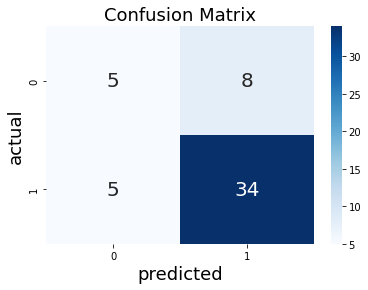

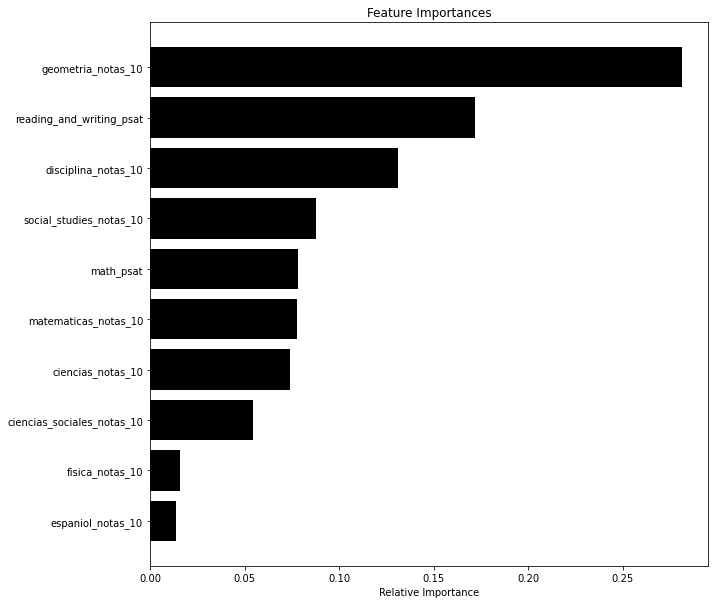

--------------------------------------------------
df_10_SOCIALES


,Accuracy,precision,Recall,f1,roc
0,0.769231,0.833333,0.875,0.853659,0.645833


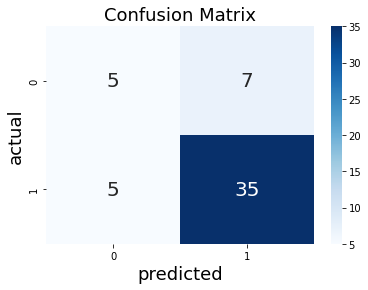

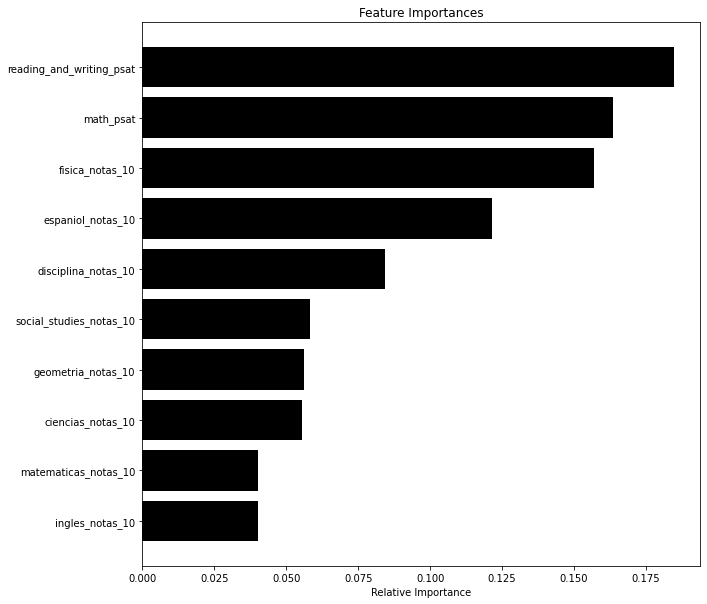

--------------------------------------------------
df_11_MATH


,Accuracy,precision,Recall,f1,roc
0,0.888889,0.925373,0.953846,0.939394,0.61978


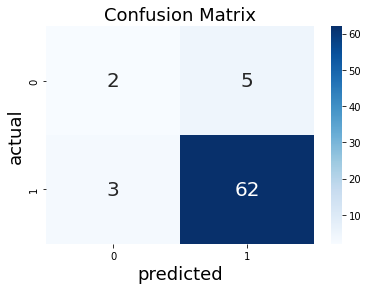

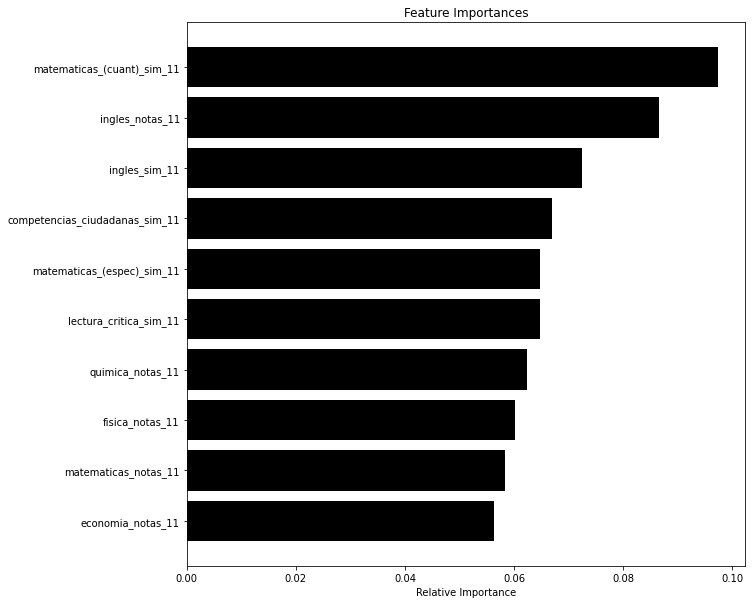

--------------------------------------------------
df_11_LECT


,Accuracy,precision,Recall,f1,roc
0,0.861111,0.882353,0.967742,0.923077,0.583871


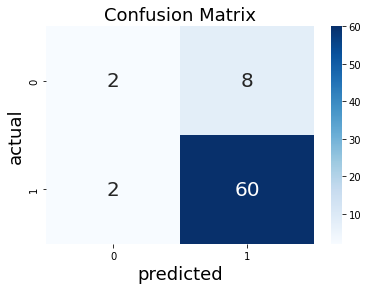

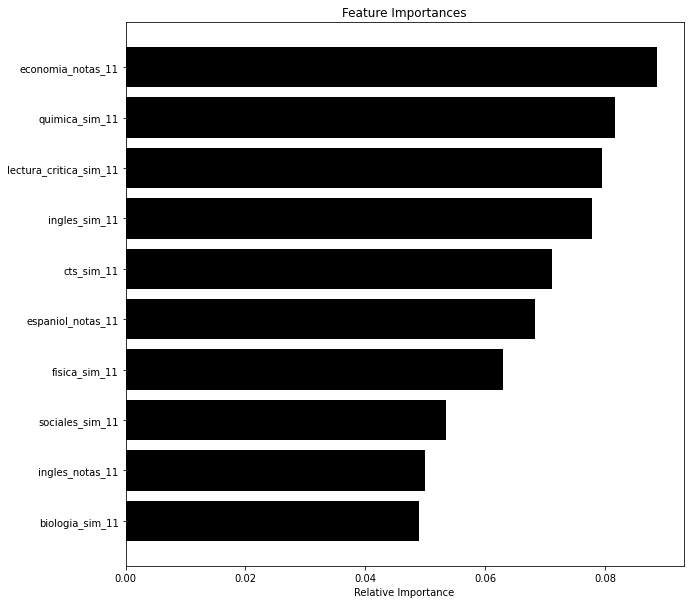

--------------------------------------------------
df_11_INGLES


,Accuracy,precision,Recall,f1,roc
0,0.819444,0.838235,0.966102,0.897638,0.559974


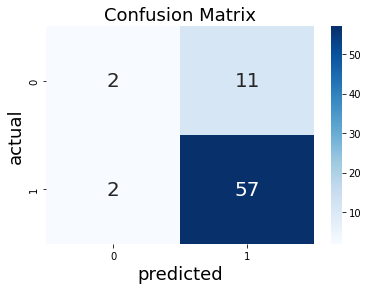

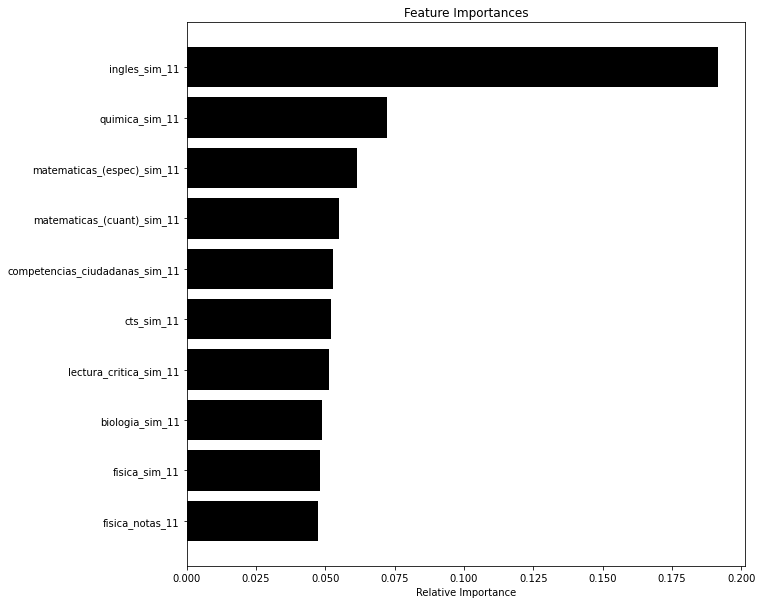

--------------------------------------------------
df_11_CIENCIAS


,Accuracy,precision,Recall,f1,roc
0,0.847222,0.9,0.915254,0.907563,0.726858


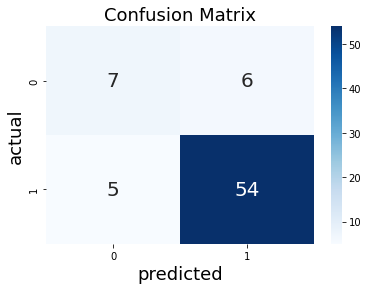

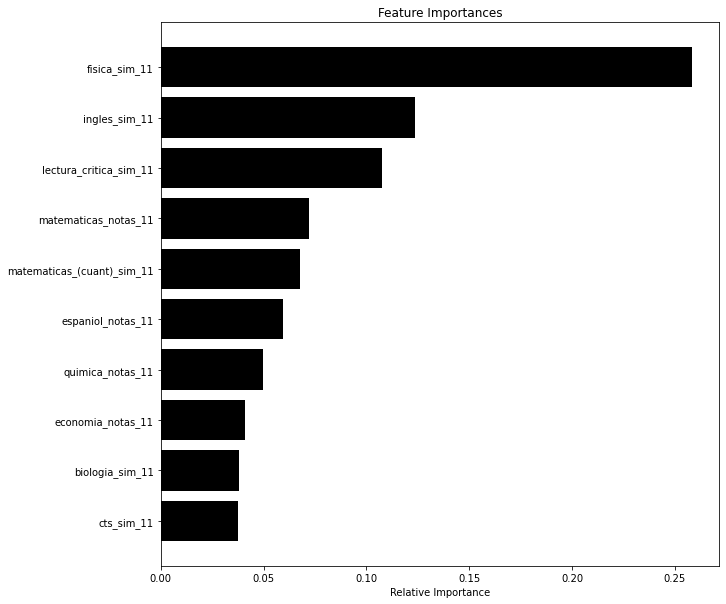

--------------------------------------------------
df_11_SOCIALES


,Accuracy,precision,Recall,f1,roc
0,0.847222,0.875,0.949153,0.910569,0.666884


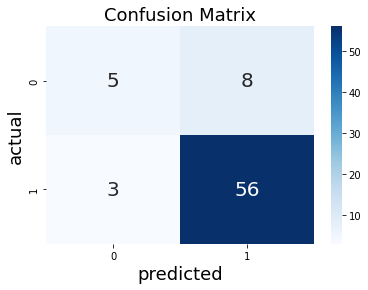

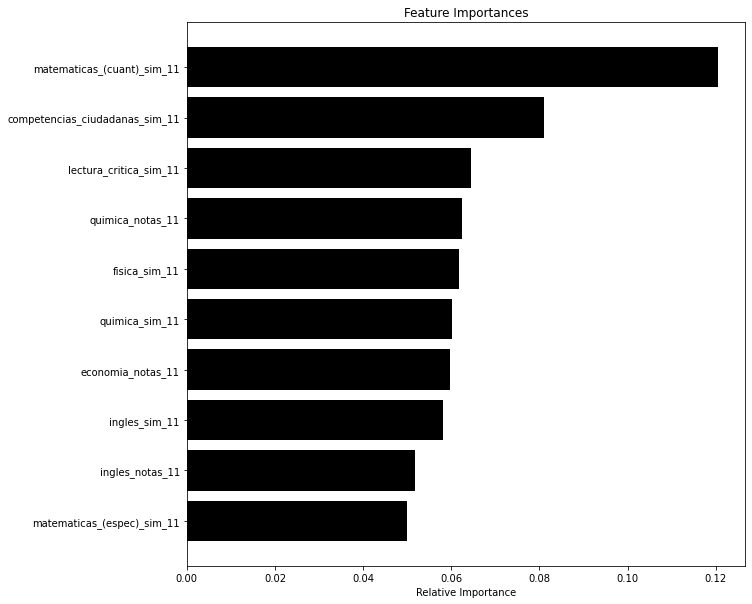

--------------------------------------------------
df_12_MATH


,Accuracy,precision,Recall,f1,roc
0,0.903226,0.912088,0.988095,0.948571,0.549603


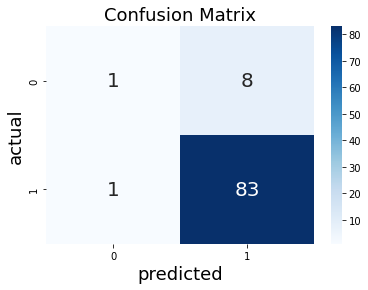

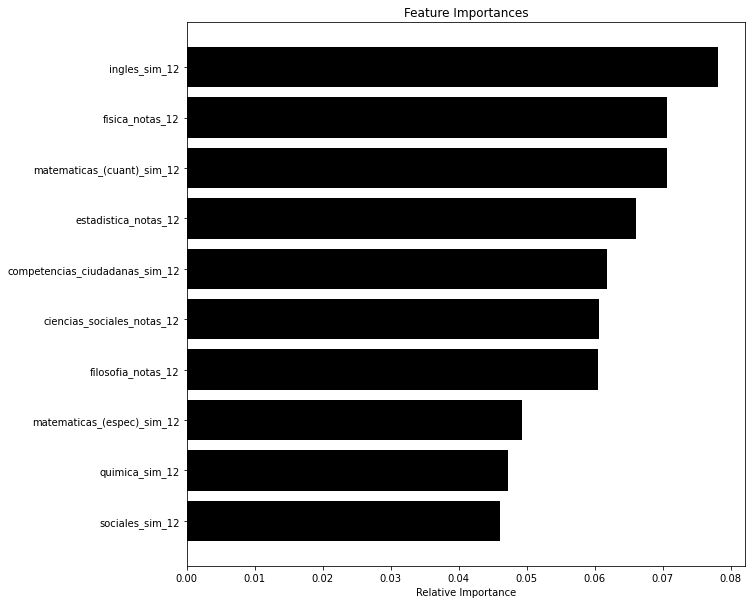

--------------------------------------------------
df_12_LECT


,Accuracy,precision,Recall,f1,roc
0,0.83871,0.853933,0.974359,0.91018,0.553846


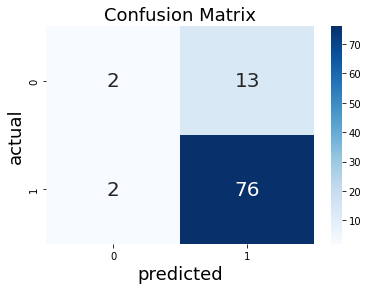

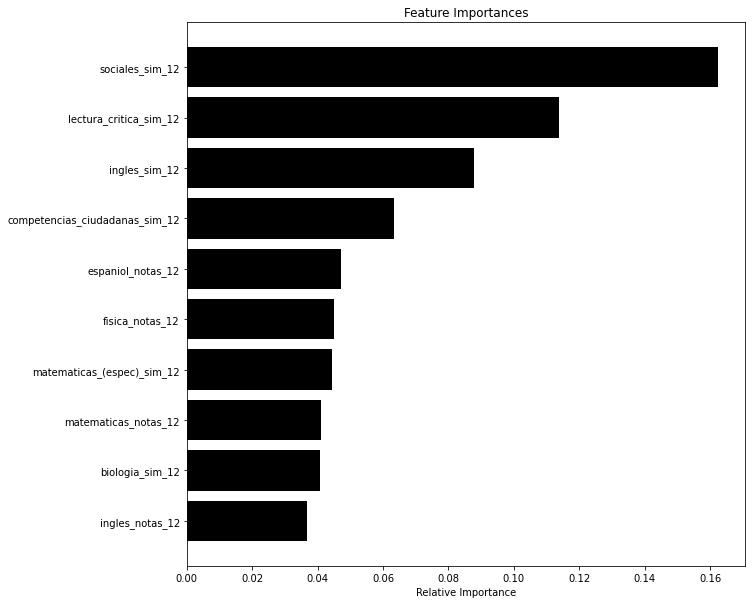

--------------------------------------------------
df_12_INGLES


,Accuracy,precision,Recall,f1,roc
0,0.806452,0.835294,0.946667,0.8875,0.584444


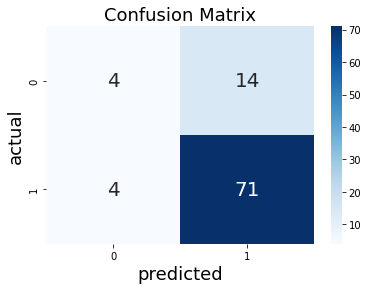

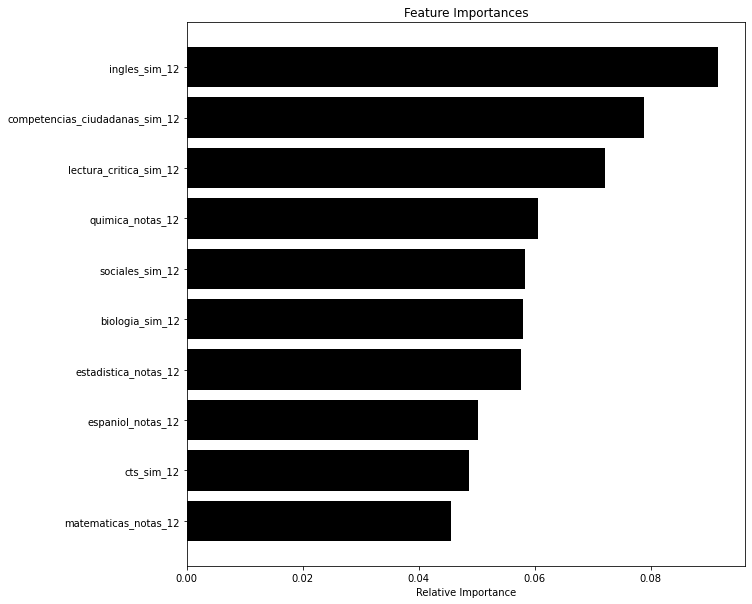

--------------------------------------------------
df_12_CIENCIAS


,Accuracy,precision,Recall,f1,roc
0,0.817204,0.873418,0.907895,0.890323,0.65983


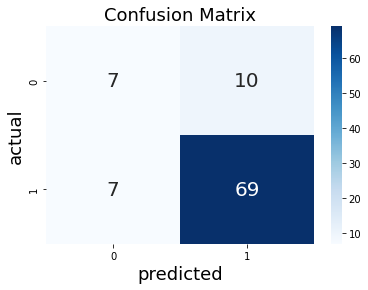

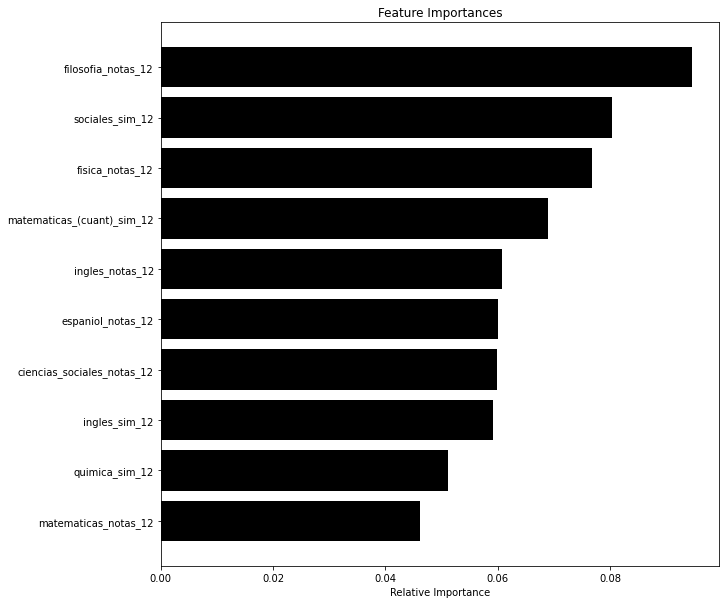

--------------------------------------------------
df_12_SOCIALES


,Accuracy,precision,Recall,f1,roc
0,0.827957,0.844156,0.942029,0.890411,0.721014


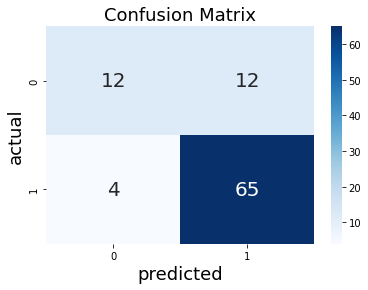

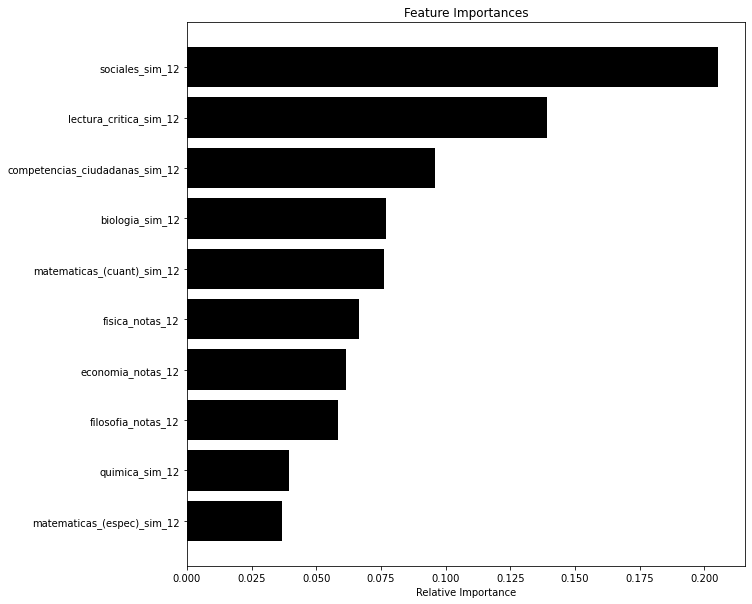

--------------------------------------------------


In [88]:
datasets_models_dict = {
    'df_10_MATH': 'rf_classifier',
    'df_10_LECT': 'rf_classifier',
    'df_10_INGLES': 'rf_classifier',
    'df_10_CIENCIAS' : 'gb_classifier',
    'df_10_SOCIALES' : 'gb_classifier',
    'df_11_MATH': 'rf_classifier',
    'df_11_LECT' : 'rf_classifier',
    'df_11_INGLES' : 'rf_classifier',
    'df_11_CIENCIAS' : 'gb_classifier',
    'df_11_SOCIALES': 'rf_classifier',
    'df_12_MATH' : 'rf_classifier',
    'df_12_LECT' : 'rf_classifier',
    'df_12_INGLES' : 'rf_classifier',
    'df_12_CIENCIAS' : 'rf_classifier',
    'df_12_SOCIALES' : 'gb_classifier',}

contador = 0
logs_metrics = pd.DataFrame()
for i in dataframes:
    try:
        del i['codigo']
    except:
        pass
    X = i.drop(columns = i.columns[-1], axis = 1)
    y = i[f'{i.columns[-1]}']
    X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)


    model_choose = datasets_models_dict[list(datasets_models_dict.keys())[contador]]
    dataset_name = list(datasets_models_dict.keys())[contador]



    if model_choose == 'rf_classifier':

        model = RandomForestClassifier()
 
      
    elif model_choose == 'gb_classifier':

        model = GradientBoostingClassifier()
        

    # Build the pipeline
    
   
    # Build the pipeline
    pipeline = Pipeline([
                    # ('Smote', SMOTE(random_state=0)),
                    ('Model', model)
                ])
    
    pipeline.fit(X_train, y_train);
    y_predict = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:,1]
    print(list(datasets_models_dict.keys())[contador])
    logs_metrics_ = evaluation(y_test, y_predict)
    logs_metrics_['data_Set'] = list(datasets_models_dict.keys())[contador]
    logs_metrics_['model'] = model_choose
    logs_metrics = logs_metrics.append(logs_metrics_)
    dataset_name_joblib = dataset_name.replace('df_','')
    # joblib.dump(pipeline,f'./models/{dataset_name_joblib}_{model_choose}.joblib')
    plot_feature_importances(model,X_train)
    print('-'*50)
    contador +=1


In [85]:
# FINALIZE DE MODELS

datasets_models_dict = {
    'df_10_MATH': 'rf_classifier',
    'df_10_LECT': 'rf_classifier',
    'df_10_INGLES': 'rf_classifier',
    'df_10_CIENCIAS' : 'gb_classifier',
    'df_10_SOCIALES' : 'gb_classifier',
    'df_11_MATH': 'rf_classifier',
    'df_11_LECT' : 'rf_classifier',
    'df_11_INGLES' : 'rf_classifier',
    'df_11_CIENCIAS' : 'gb_classifier',
    'df_11_SOCIALES': 'rf_classifier',
    'df_12_MATH' : 'rf_classifier',
    'df_12_LECT' : 'rf_classifier',
    'df_12_INGLES' : 'rf_classifier',
    'df_12_CIENCIAS' : 'rf_classifier',
    'df_12_SOCIALES' : 'gb_classifier',}

contador = 0
logs_metrics = pd.DataFrame()
for i in dataframes:
    try:
        del i['codigo']
    except:
        pass
    X = i.drop(columns = i.columns[-1], axis = 1)
    y = i[f'{i.columns[-1]}']


    model_choose = datasets_models_dict[list(datasets_models_dict.keys())[contador]]
    dataset_name = list(datasets_models_dict.keys())[contador]


    if model_choose == 'rf_classifier':

        model = RandomForestClassifier()
 
      
    elif model_choose == 'gb_classifier':

        model = GradientBoostingClassifier()
        

    # Build the pipeline
    
   
    # Build the pipeline
    pipeline = Pipeline([
                    # ('Smote', SMOTE(random_state=0)),
                    ('Model', model)
                ])
    
    pipeline.fit(X, y);
    # y_predict = pipeline.predict(X_test)
    # y_pred_proba = pipeline.predict_proba(X_test)[:,1]
    # print(list(datasets_models_dict.keys())[contador])
    # logs_metrics_ = evaluation(y_test, y_predict)
    # logs_metrics_['data_Set'] = list(datasets_models_dict.keys())[contador]
    # logs_metrics = logs_metrics.append(logs_metrics_)
    dataset_name_joblib = dataset_name.replace('df_','')
    joblib.dump(pipeline,f'./models/{dataset_name_joblib}_{model_choose}.joblib')
    print('-'*50)
    contador +=1


--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------


In [199]:
def evaluation(y_test, y_predict, path_name_plot:str, title = 'Confusion Matrix'):
    cm = confusion_matrix(y_test, y_predict)
    
    # print('Recall: ', recall)
    # print('Accuracy: ', accuracy)
    # print('Precision: ', precision)
    # print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'Blues', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=12)
    plt.ylabel('actual', fontsize=12)
    plt.title(title, fontsize=12)
    fig1 = plt.gcf()
    fig1.savefig(f"{path_name_plot}_cm.png", dpi=100)
    plt.show()



def plot_feature_importances(model,X_train,path_name_plot,title):
    features = X_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)

    # customized number 
    num_features = 5

    plt.figure(figsize=(10,10))
    plt.title('Feature Importances')

    # only plot the customized number of features
    plt.barh(range(num_features), importances[indices[-num_features:]], color='blue', align='center')
    plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
    plt.xlabel('Relative Importance')
    plt.title(title, fontsize=12)
    
    fig1 = plt.gcf()
    fig1.savefig(f"{path_name_plot}_fi.png", dpi=100)
    plt.show()


def save_metrics_chart(logs_to_plot,dataset_name):
    metric = list(logs_to_plot.keys())
    values = list(logs_to_plot.values())
    fig = plt.figure(figsize =(10, 7))
    sns.barplot(metric, values)
    plt.title(f'Evaluation Metrics\nDataset: {dataset_name}  -  Model: {model_choose}')
    plt.yticks(np.arange(0,1,0.1));
    fig1 = plt.gcf()
    fig1.savefig(f'./graphs/metrics graphs/{dataset_name}_metrics.png', dpi=100)
    plt.show()
    # plt.savefig()

def metrics(y_test, y_predict):
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    accuracy = accuracy_score(y_test,y_predict)
    f1 = f1_score(y_test,y_predict)
    roc = roc_auc_score(y_test, y_predict)
    metrics = {'Accuracy':accuracy,
                'precision':precision,
                'Recall':recall,
                'f1':f1,
                'roc' : roc
                 }

    metrics_df = pd.DataFrame([metrics])
    return metrics_df

df_10_MATH


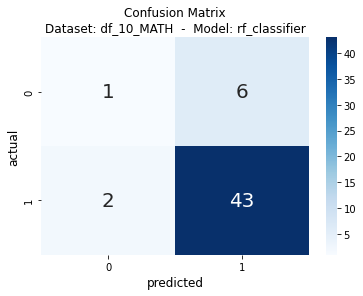

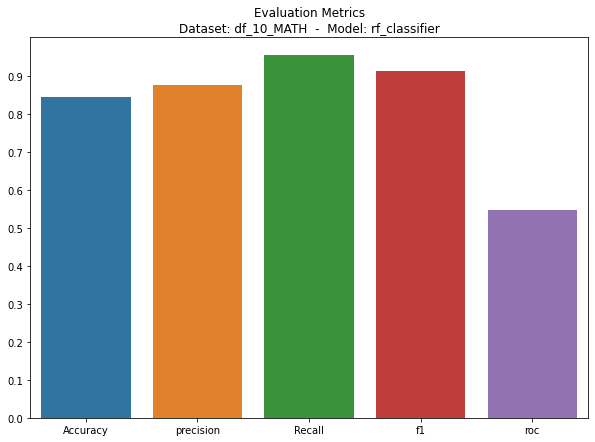

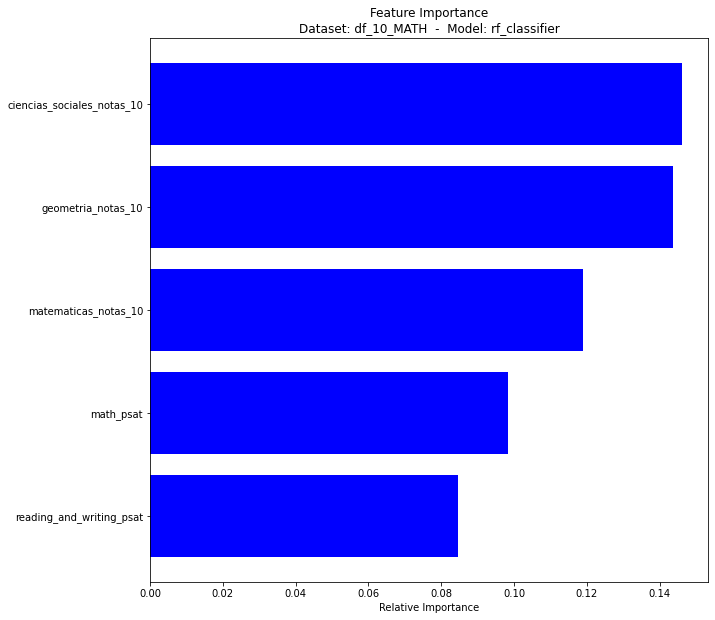

--------------------------------------------------
df_10_LECT


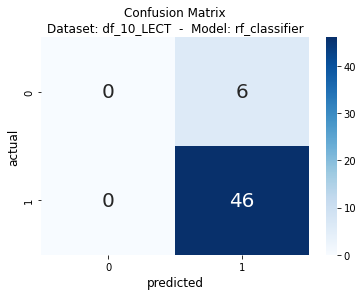

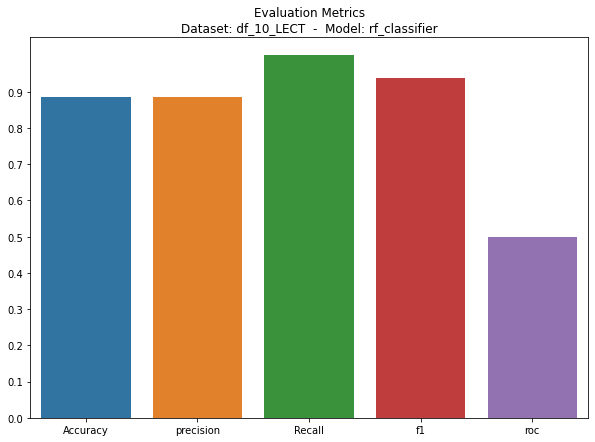

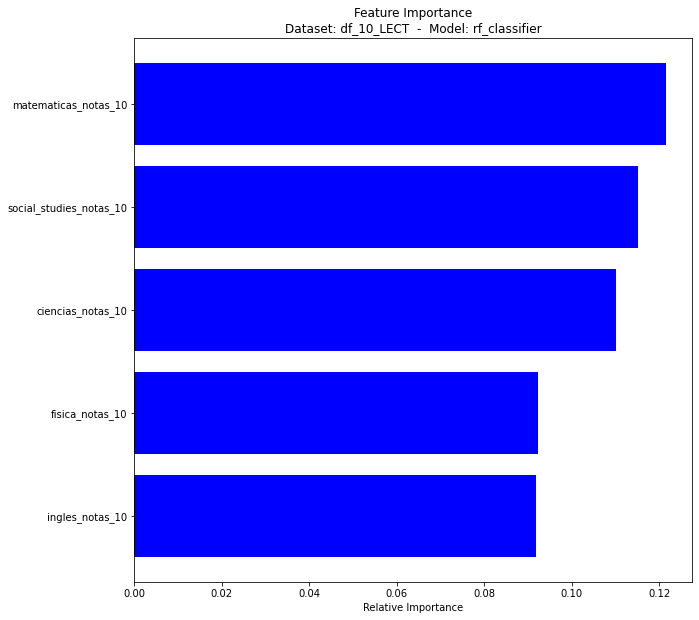

--------------------------------------------------
df_10_INGLES


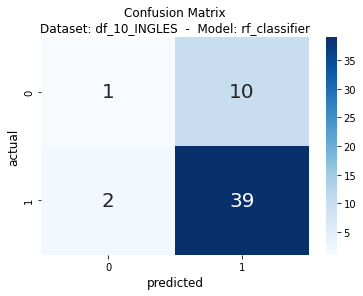

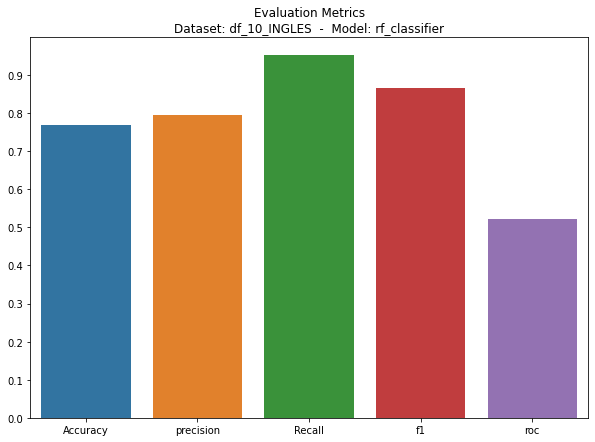

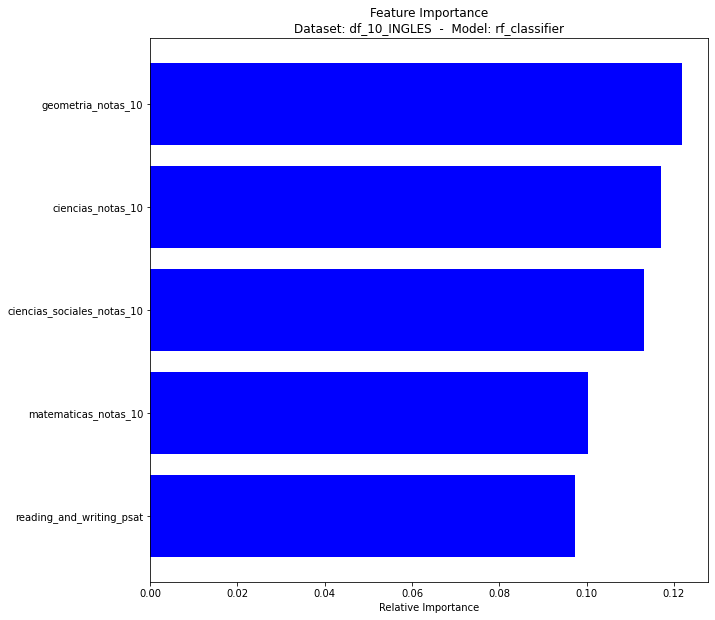

--------------------------------------------------
df_10_CIENCIAS


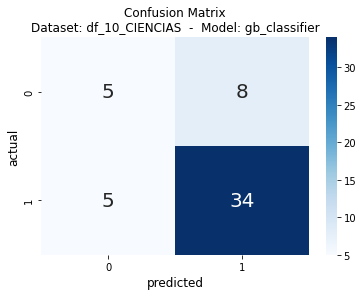

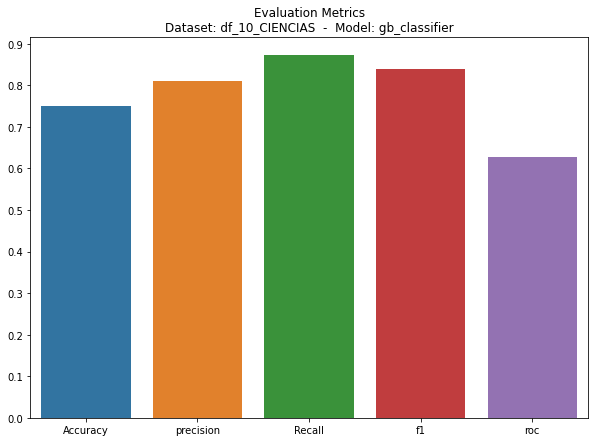

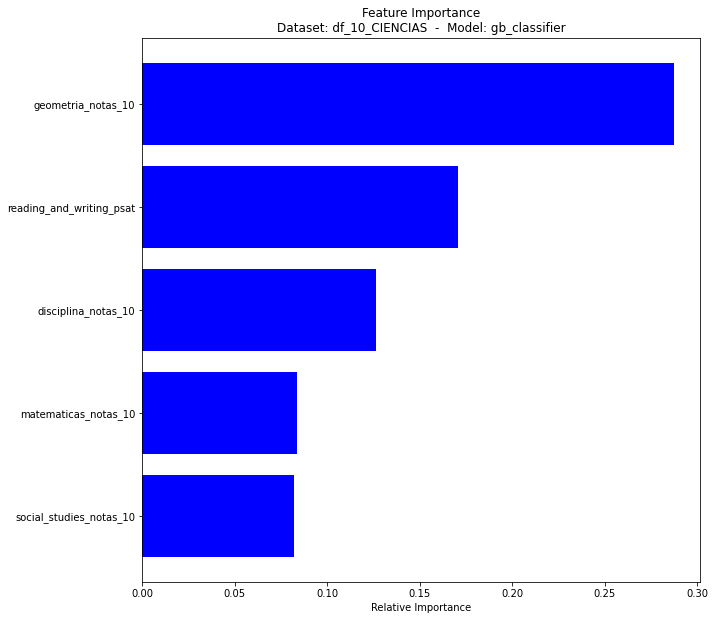

--------------------------------------------------
df_10_SOCIALES


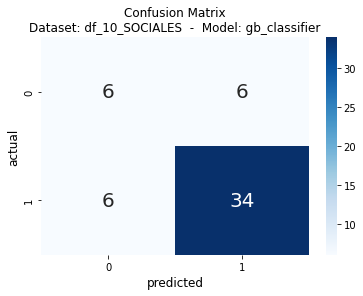

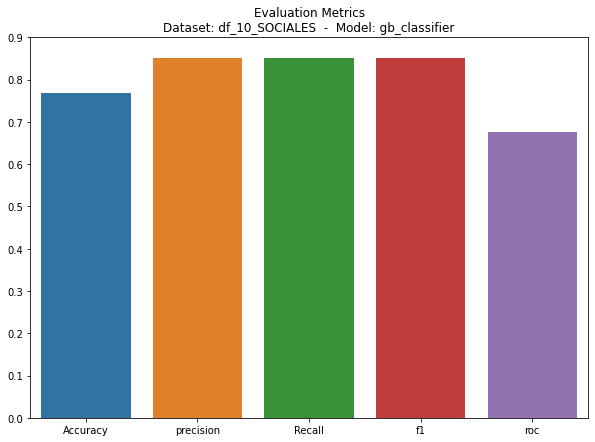

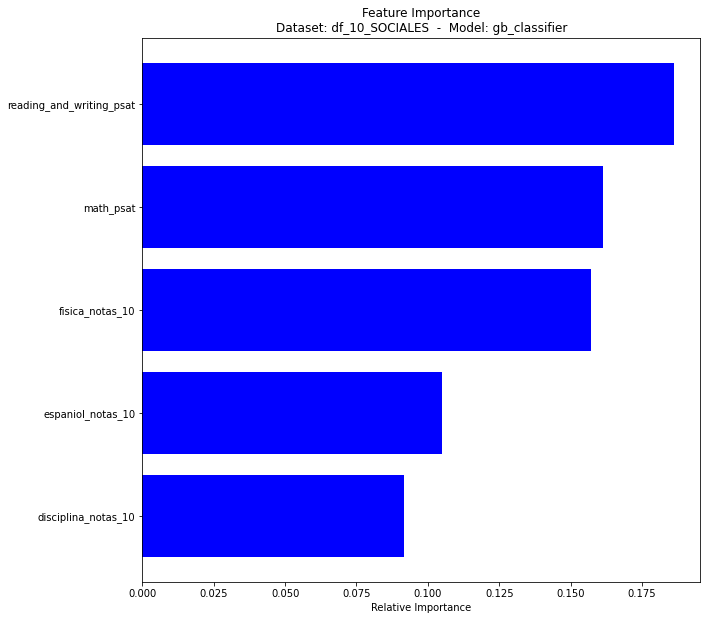

--------------------------------------------------
df_11_MATH


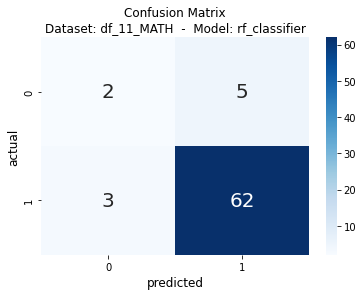

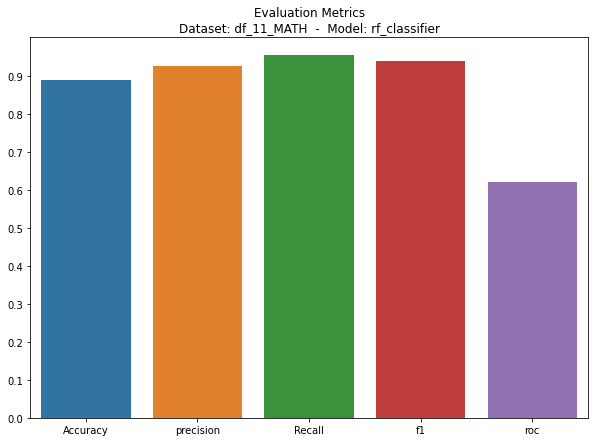

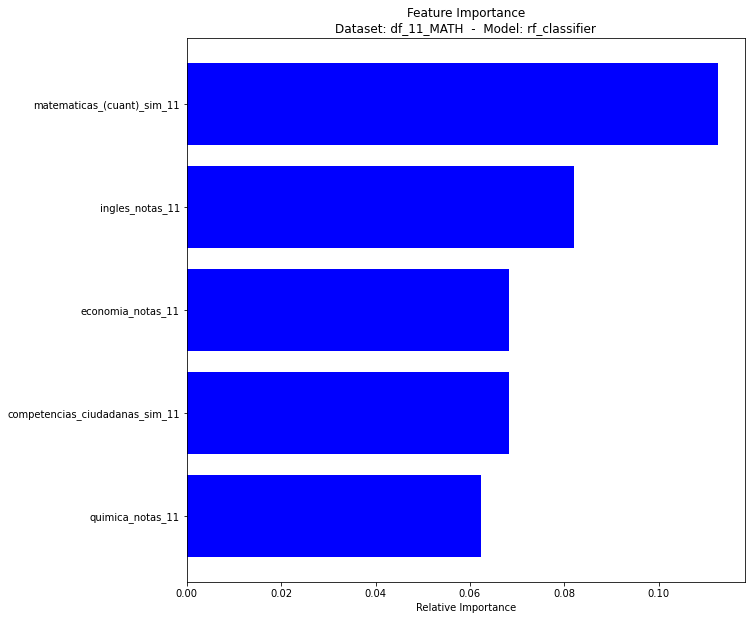

--------------------------------------------------
df_11_LECT


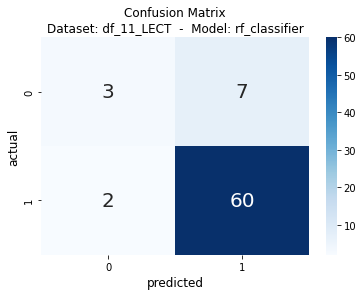

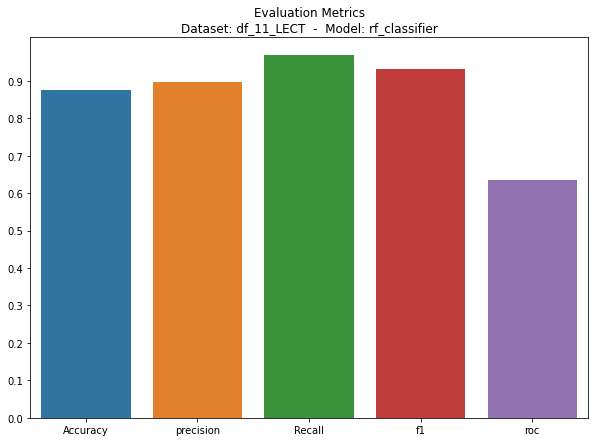

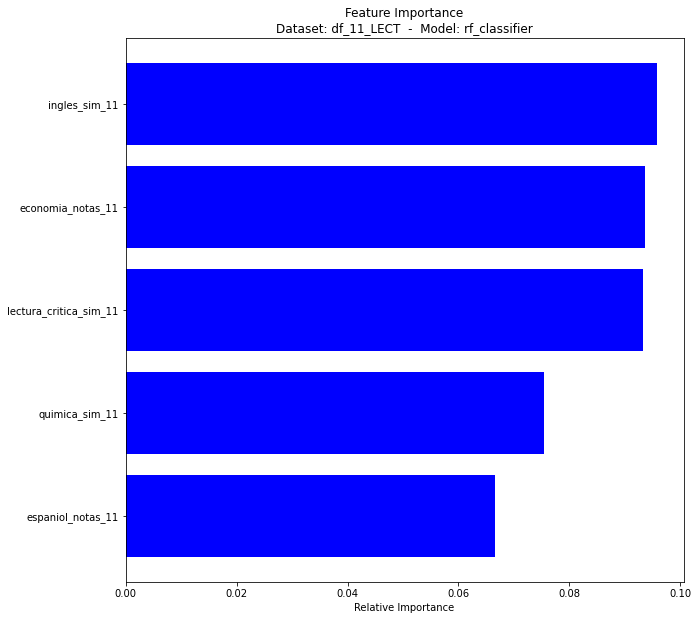

--------------------------------------------------
df_11_INGLES


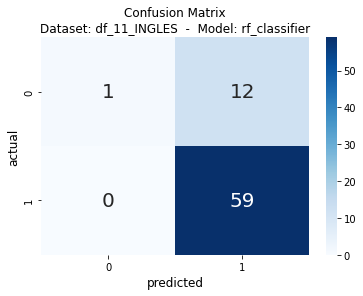

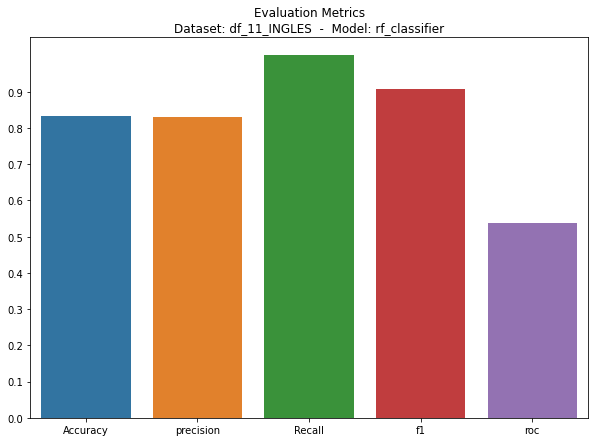

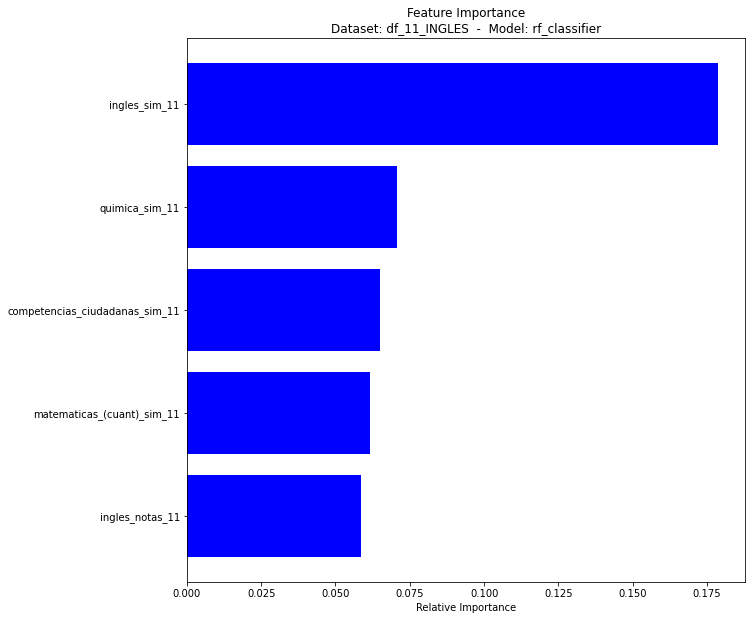

--------------------------------------------------
df_11_CIENCIAS


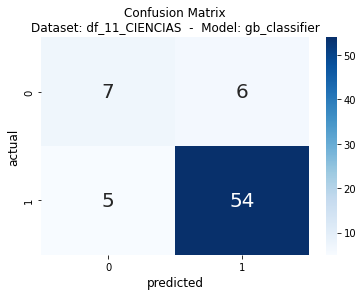

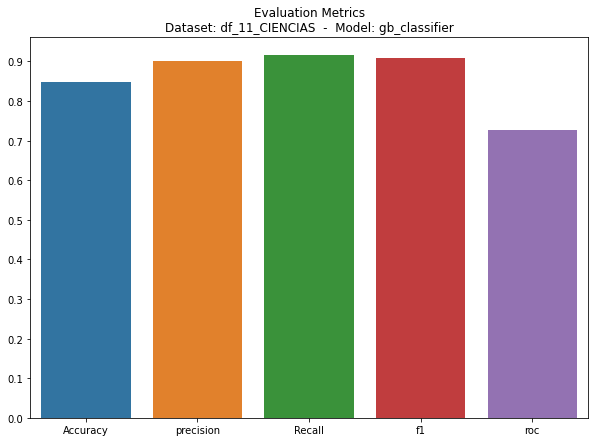

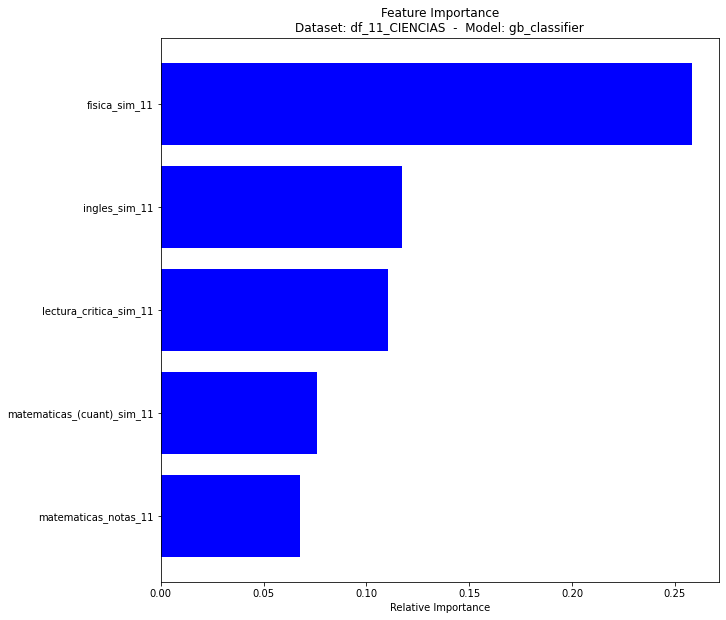

--------------------------------------------------
df_11_SOCIALES


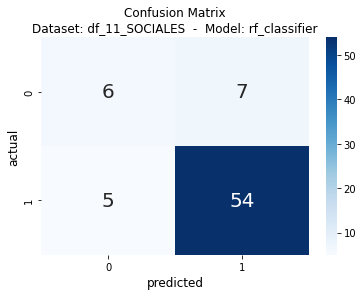

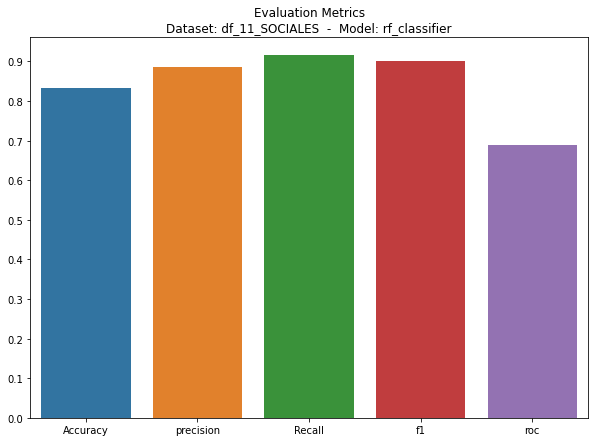

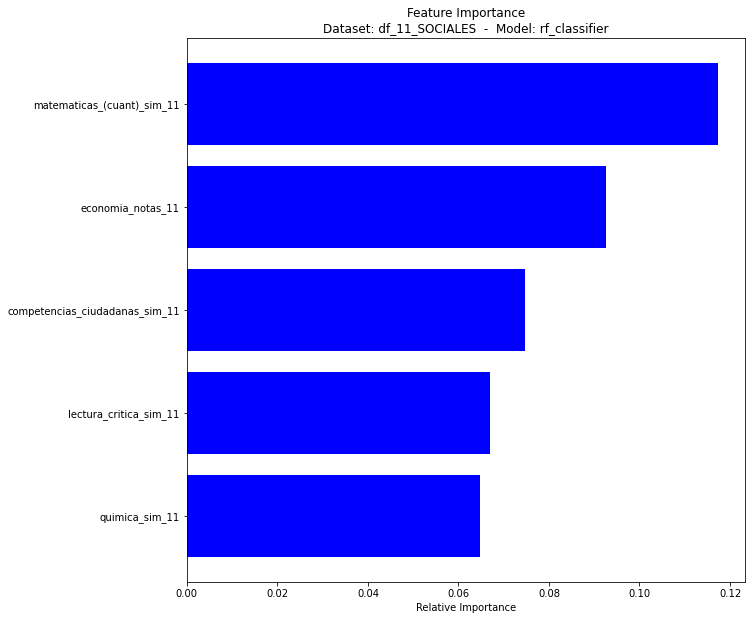

--------------------------------------------------
df_12_MATH


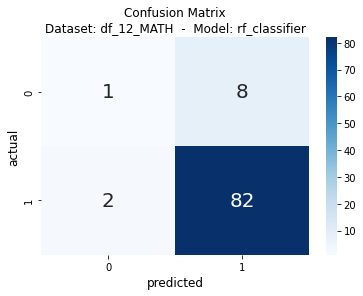

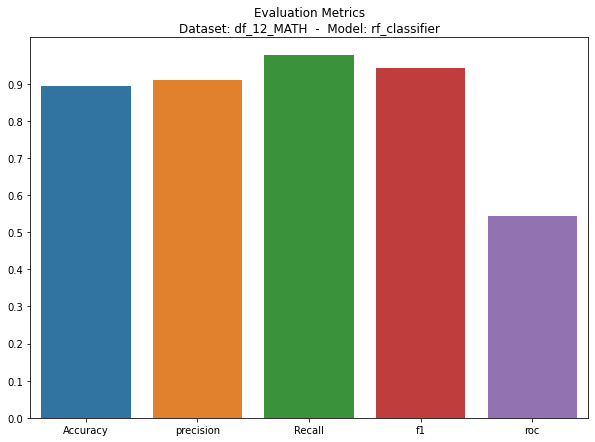

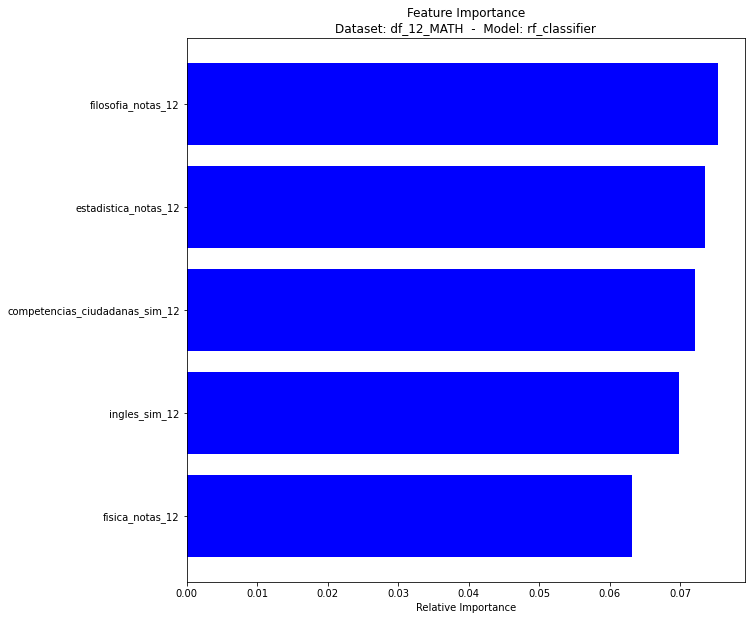

--------------------------------------------------
df_12_LECT


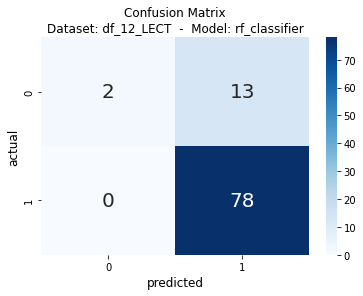

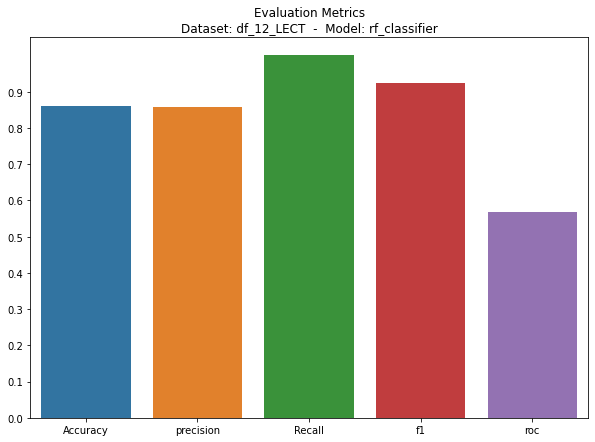

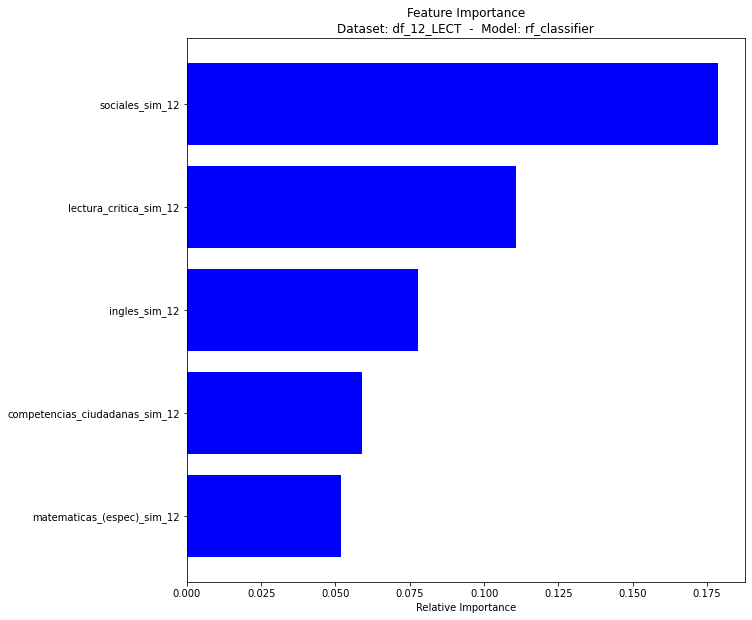

--------------------------------------------------
df_12_INGLES


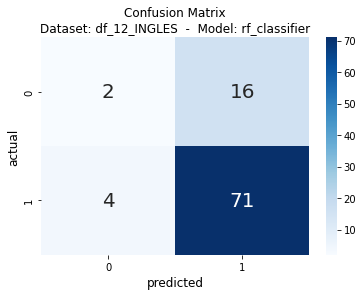

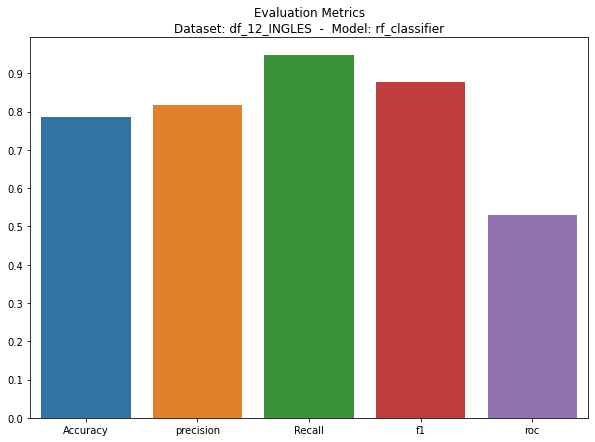

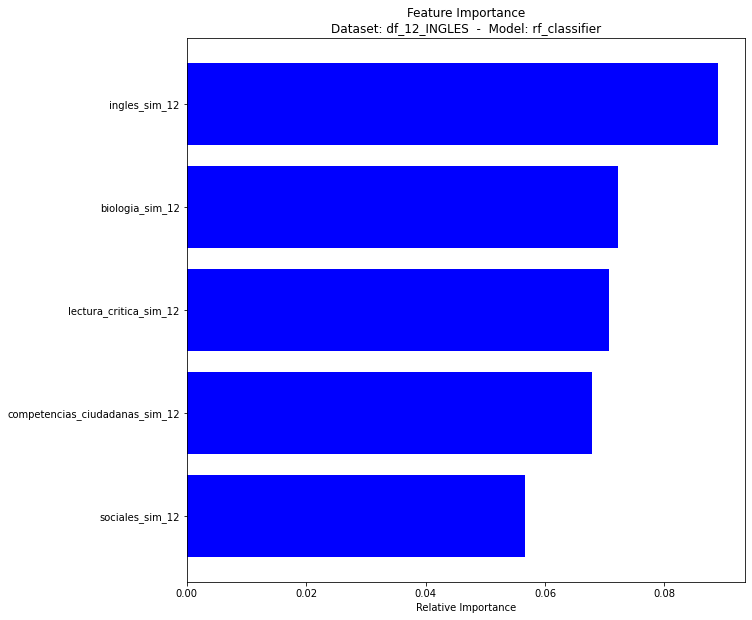

--------------------------------------------------
df_12_CIENCIAS


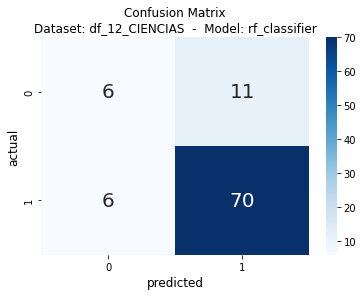

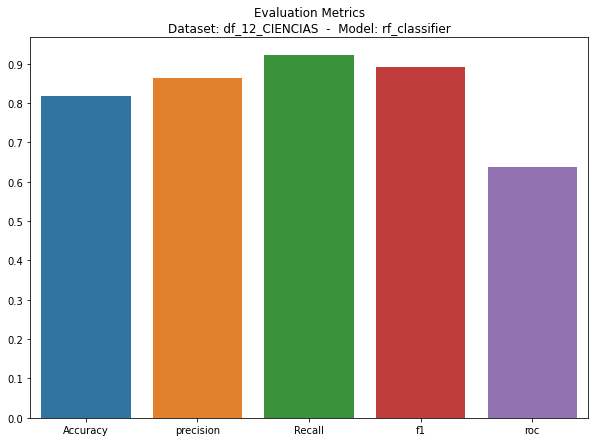

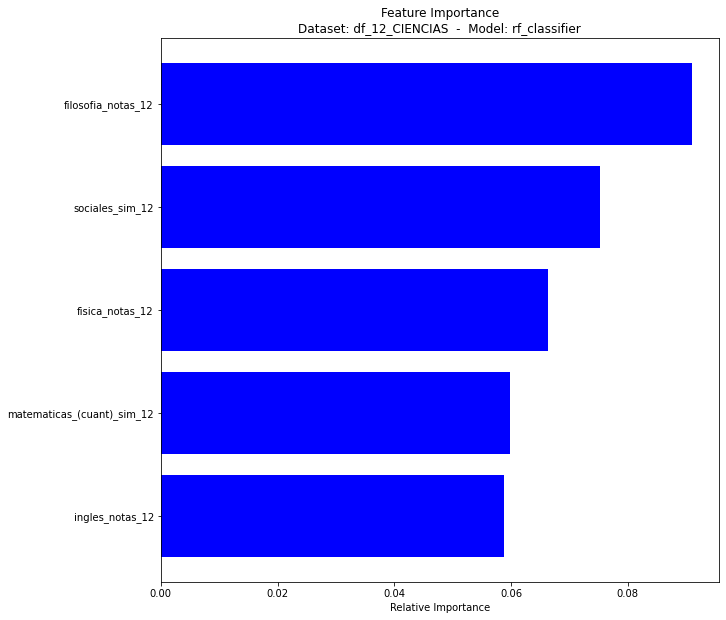

--------------------------------------------------
df_12_SOCIALES


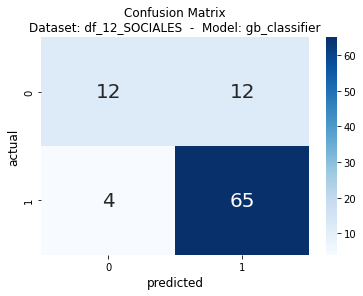

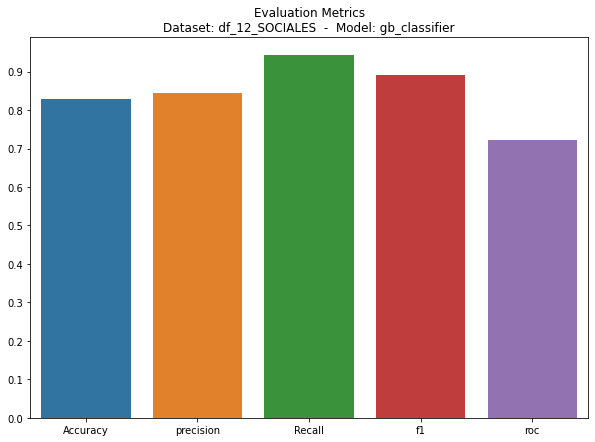

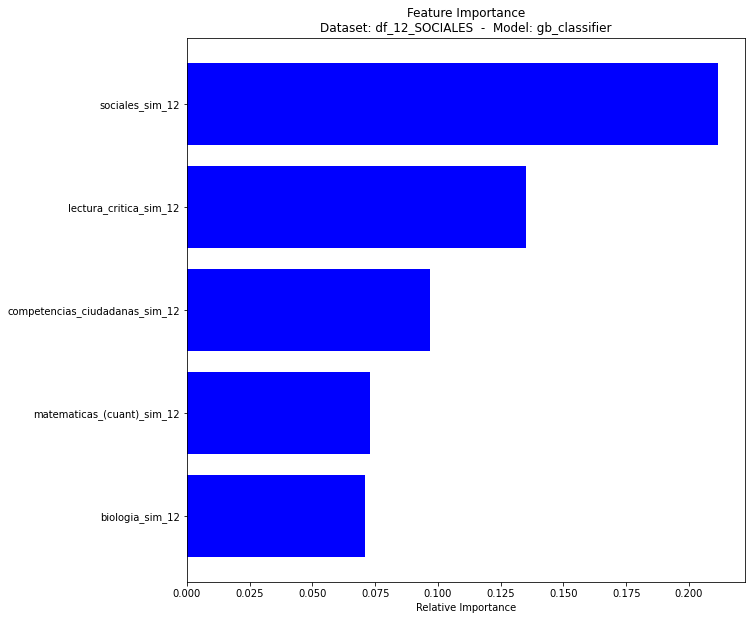

--------------------------------------------------


In [200]:
datasets_models_dict = {
    'df_10_MATH': 'rf_classifier',
    'df_10_LECT': 'rf_classifier',
    'df_10_INGLES': 'rf_classifier',
    'df_10_CIENCIAS' : 'gb_classifier',
    'df_10_SOCIALES' : 'gb_classifier',
    'df_11_MATH': 'rf_classifier',
    'df_11_LECT' : 'rf_classifier',
    'df_11_INGLES' : 'rf_classifier',
    'df_11_CIENCIAS' : 'gb_classifier',
    'df_11_SOCIALES': 'rf_classifier',
    'df_12_MATH' : 'rf_classifier',
    'df_12_LECT' : 'rf_classifier',
    'df_12_INGLES' : 'rf_classifier',
    'df_12_CIENCIAS' : 'rf_classifier',
    'df_12_SOCIALES' : 'gb_classifier',}

contador = 0
logs_metrics = pd.DataFrame()
for i in dataframes:
    try:
        del i['codigo']
    except:
        pass
    X = i.drop(columns = i.columns[-1], axis = 1)
    y = i[f'{i.columns[-1]}']
    X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)


    model_choose = datasets_models_dict[list(datasets_models_dict.keys())[contador]]
    dataset_name = list(datasets_models_dict.keys())[contador]



    if model_choose == 'rf_classifier':

        model = RandomForestClassifier()
 
      
    elif model_choose == 'gb_classifier':

        model = GradientBoostingClassifier()
        

    # Build the pipeline
    
   
    # Build the pipeline
    pipeline = Pipeline([
                    # ('Smote', SMOTE(random_state=0)),
                    ('Model', model)
                ])
    
    pipeline.fit(X_train, y_train);
    y_predict = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:,1]
    print(list(datasets_models_dict.keys())[contador])
    evaluation(y_test, y_predict, path_name_plot = f'./graphs/metrics graphs/{dataset_name}', title = f'Confusion Matrix\nDataset: {dataset_name}  -  Model: {model_choose}' )
    logs_metrics_ = metrics(y_test, y_predict)
    logs_metrics_['data_Set'] = list(datasets_models_dict.keys())[contador]
    logs_metrics_['model'] = model_choose
    logs_metrics = logs_metrics.append(logs_metrics_)
    dataset_name_joblib = dataset_name.replace('df_','')
    logs_to_plot = logs_metrics_[['Accuracy', 'precision', 'Recall', 'f1', 'roc']]
    logs_to_plot = logs_to_plot.to_dict(orient = 'records')[0]
    save_metrics_chart(logs_to_plot,dataset_name)
    plot_feature_importances(model,X_train,path_name_plot = f'./graphs/metrics graphs/{dataset_name}', title = f'Feature Importance\nDataset: {dataset_name}  -  Model: {model_choose}')
    print('-'*50)
    contador +=1


In [188]:
datasets = ['df_10_MATH', 'df_10_LECT', 'df_10_INGLES', 'df_10_CIENCIAS', 'df_10_SOCIALES', 'df_11_MATH', 'df_11_LECT', 'df_11_INGLES', 'df_11_CIENCIAS', 'df_11_SOCIALES', 'df_12_MATH', 'df_12_LECT', 'df_12_INGLES', 'df_12_CIENCIAS', 'df_12_SOCIALES']

In [189]:
text = ''
for i in datasets:
    text += f"{{'{i}': ['./graphs/metrics graphs/{i}_cm.png','./graphs/metrics graphs/{i}_fi.png','./graphs/metrics graphs/{i}_metrics.png']}}," 

In [190]:
text

"{'df_10_MATH': ['./graphs/metrics graphs/df_10_MATH_cm.png','./graphs/metrics graphs/df_10_MATH_fi.png','./graphs/metrics graphs/df_10_MATH_metrics.png']},{'df_10_LECT': ['./graphs/metrics graphs/df_10_LECT_cm.png','./graphs/metrics graphs/df_10_LECT_fi.png','./graphs/metrics graphs/df_10_LECT_metrics.png']},{'df_10_INGLES': ['./graphs/metrics graphs/df_10_INGLES_cm.png','./graphs/metrics graphs/df_10_INGLES_fi.png','./graphs/metrics graphs/df_10_INGLES_metrics.png']},{'df_10_CIENCIAS': ['./graphs/metrics graphs/df_10_CIENCIAS_cm.png','./graphs/metrics graphs/df_10_CIENCIAS_fi.png','./graphs/metrics graphs/df_10_CIENCIAS_metrics.png']},{'df_10_SOCIALES': ['./graphs/metrics graphs/df_10_SOCIALES_cm.png','./graphs/metrics graphs/df_10_SOCIALES_fi.png','./graphs/metrics graphs/df_10_SOCIALES_metrics.png']},{'df_11_MATH': ['./graphs/metrics graphs/df_11_MATH_cm.png','./graphs/metrics graphs/df_11_MATH_fi.png','./graphs/metrics graphs/df_11_MATH_metrics.png']},{'df_11_LECT': ['./graphs/met

In [155]:
    dict_datos = [{'df_10_MATH': ['./graphs/metrics graphs/df_10_MATH_cm.png','./graphs/metrics graphs/df_10_MATH_fi.png','./graphs/metrics graphs/df_10_MATH_metrics.png']},
    {'df_10_LECT': ['./graphs/metrics graphs/df_10_LECT_cm.png','./graphs/metrics graphs/df_10_LECT_fi.png','./graphs/metrics graphs/df_10_LECT_metrics.png']},
    {'df_10_INGLES': ['./graphs/metrics graphs/df_10_INGLES_cm.png','./graphs/metrics graphs/df_10_INGLES_fi.png','./graphs/metrics graphs/df_10_INGLES_metrics.png']},
    {'df_10_CIENCIAS': ['./graphs/metrics graphs/df_10_CIENCIAS_cm.png','./graphs/metrics graphs/df_10_CIENCIAS_fi.png','./graphs/metrics graphs/df_10_CIENCIAS_metrics.png']},
    {'df_10_SOCIALES': ['./graphs/metrics graphs/df_10_SOCIALES_cm.png','./graphs/metrics graphs/df_10_SOCIALES_fi.png','./graphs/metrics graphs/df_10_SOCIALES_metrics.png']},
    {'df_11_MATH': ['./graphs/metrics graphs/df_11_MATH_cm.png','./graphs/metrics graphs/df_11_MATH_fi.png','./graphs/metrics graphs/df_11_MATH_metrics.png']},
    {'df_11_LECT': ['./graphs/metrics graphs/df_11_LECT_cm.png','./graphs/metrics graphs/df_11_LECT_fi.png','./graphs/metrics graphs/df_11_LECT_metrics.png']},
    {'df_11_INGLES': ['./graphs/metrics graphs/df_11_INGLES_cm.png','./graphs/metrics graphs/df_11_INGLES_fi.png','./graphs/metrics graphs/df_11_INGLES_metrics.png']},
    {'df_11_CIENCIAS': ['./graphs/metrics graphs/df_11_CIENCIAS_cm.png','./graphs/metrics graphs/df_11_CIENCIAS_fi.png','./graphs/metrics graphs/df_11_CIENCIAS_metrics.png']},
    {'df_11_SOCIALES': ['./graphs/metrics graphs/df_11_SOCIALES_cm.png','./graphs/metrics graphs/df_11_SOCIALES_fi.png','./graphs/metrics graphs/df_11_SOCIALES_metrics.png']},
    {'df_12_MATH': ['./graphs/metrics graphs/df_12_MATH_cm.png','./graphs/metrics graphs/df_12_MATH_fi.png','./graphs/metrics graphs/df_12_MATH_metrics.png']},
    {'df_12_LECT': ['./graphs/metrics graphs/df_12_LECT_cm.png','./graphs/metrics graphs/df_12_LECT_fi.png','./graphs/metrics graphs/df_12_LECT_metrics.png']},
    {'df_12_INGLES': ['./graphs/metrics graphs/df_12_INGLES_cm.png','./graphs/metrics graphs/df_12_INGLES_fi.png','./graphs/metrics graphs/df_12_INGLES_metrics.png']},
    {'df_12_CIENCIAS': ['./graphs/metrics graphs/df_12_CIENCIAS_cm.png','./graphs/metrics graphs/df_12_CIENCIAS_fi.png','./graphs/metrics graphs/df_12_CIENCIAS_metrics.png']},
    {'df_12_SOCIALES': ['./graphs/metrics graphs/df_12_SOCIALES_cm.png','./graphs/metrics graphs/df_12_SOCIALES_fi.png','./graphs/metrics graphs/df_12_SOCIALES_metrics.png']}]


In [163]:
datasets_strings = [
    'df_10_MATH',
    'df_10_LECT',
    'df_10_INGLES',
    'df_10_CIENCIAS' ,
    'df_10_SOCIALES' ,
    'df_11_MATH',
    'df_11_LECT' ,
    'df_11_INGLES' ,
    'df_11_CIENCIAS' ,
    'df_11_SOCIALES',
    'df_12_MATH' ,
    'df_12_LECT' ,
    'df_12_INGLES' ,
    'df_12_CIENCIAS' ,
    'df_12_SOCIALES' ]

In [184]:
for i in datasets_strings:
    for j in dict_datos:
        if list(j.keys())[0] == i:
            cm = j[i][0]
            fi = j[i][1]
            metrics = j[i][2]
            print(cm)

./graphs/metrics graphs/df_10_MATH_cm.png
./graphs/metrics graphs/df_10_LECT_cm.png
./graphs/metrics graphs/df_10_INGLES_cm.png
./graphs/metrics graphs/df_10_CIENCIAS_cm.png
./graphs/metrics graphs/df_10_SOCIALES_cm.png
./graphs/metrics graphs/df_11_MATH_cm.png
./graphs/metrics graphs/df_11_LECT_cm.png
./graphs/metrics graphs/df_11_INGLES_cm.png
./graphs/metrics graphs/df_11_CIENCIAS_cm.png
./graphs/metrics graphs/df_11_SOCIALES_cm.png
./graphs/metrics graphs/df_12_MATH_cm.png
./graphs/metrics graphs/df_12_LECT_cm.png
./graphs/metrics graphs/df_12_INGLES_cm.png
./graphs/metrics graphs/df_12_CIENCIAS_cm.png
./graphs/metrics graphs/df_12_SOCIALES_cm.png


In [181]:
list(j.keys())[0]

'df_12_SOCIALES'